In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [24]:
def plot_blob_results(models,
                 x_test,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 64
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [185]:
def z_visual(models):
    encoder, decoder = models
    n = 20
    digit_size = 64
    figure = np.zeros((digit_size * latent_dim, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = range(latent_dim)
    
#     seed_idx = np.random.randint(0, imgs.shape[0])
#     seed_image = imgs[seed_idx:seed_idx+1, :, :, 0:1]
    seed_image = get_blob(1)
    z_traversal = encoder.predict(seed_image)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_temp = np.copy(z_traversal[2])
            z_temp[0, i] = xi
            x_decoded = decoder.predict(z_temp)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            digit[0, :] = 1
            digit[:, 0] = 1
            digit[-1, :] = 1
            digit[:, -1] = 1
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize = (25, 25))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z_value")
    plt.ylabel("z_index")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [198]:
# dSprite dataset
dataset_zip = np.load('dsprite.npz', encoding="latin1")

imgs = dataset_zip['imgs']
imgs = imgs.reshape([-1, 64, 64, 1])
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]
print('Latent Names:', metadata['latents_names'])

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

Latent Names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')


In [199]:
def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

In [11]:
def normalize(x):
    x = (x - x.min())/(x.max() - x.min() + 1e-8)
    return x

def get_blob(size):
    blobs = np.zeros((size, 64, 64, 1))
    for i in range(size):
        blob = np.zeros((64, 64))
        idx_x = np.random.randint(10, 54)
        idx_y = np.random.randint(10, 54)
        blob[idx_x, idx_y] = 1
#         blur_radius = np.random.randint(0, 10) * 2 + 11
        blur_radius = 21
        blur = cv2.GaussianBlur(blob,(blur_radius, blur_radius),0)
        blobs[i, :, :, 0] = normalize(blur)
    return blobs

image_size = 64
x_train = get_blob(15000)
x_test = get_blob(1000)

In [221]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 10
epochs = 30
beta = 1

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

use_mse = True

# VAE loss = mse_loss or xent_loss + kl_loss
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + beta*kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

load_weights = False
if load_weights:
    vae = vae.load_weights('vae_cnn_dSprite.h5')
else:
    # train the autoencoder
    latents_sampled = sample_latent(15000)
    indices_sampled = latent_to_index(latents_sampled)
    x_train = imgs[indices_sampled]
    
    latents_sampled = sample_latent(1000)
    indices_sampled = latent_to_index(latents_sampled)
    x_test = imgs[indices_sampled]
    
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn_dSprite.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 16, 16, 64)   18496       conv2d_29[0][0]                  
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 16384)        0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
dense_29 (

c:\users\yliu60\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  281316    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         235905    
Total params: 517,221
Trainable params: 517,221
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 1000 samples
Epoch 1/30
15000/15000 [==============================] - 12s 798us/step - loss: 298.8147 - val_loss: 141.6106
Epoch 2/30
15000/15000 [==============================] - 9s 607us/step - loss: 120.9064 - val_loss: 103.2874
Epoch 3/30
15000/15000 [==============================] - 9s 605us/step - loss: 94.9492 - val_loss: 89.9447
Epoch 4/30
15000/15000

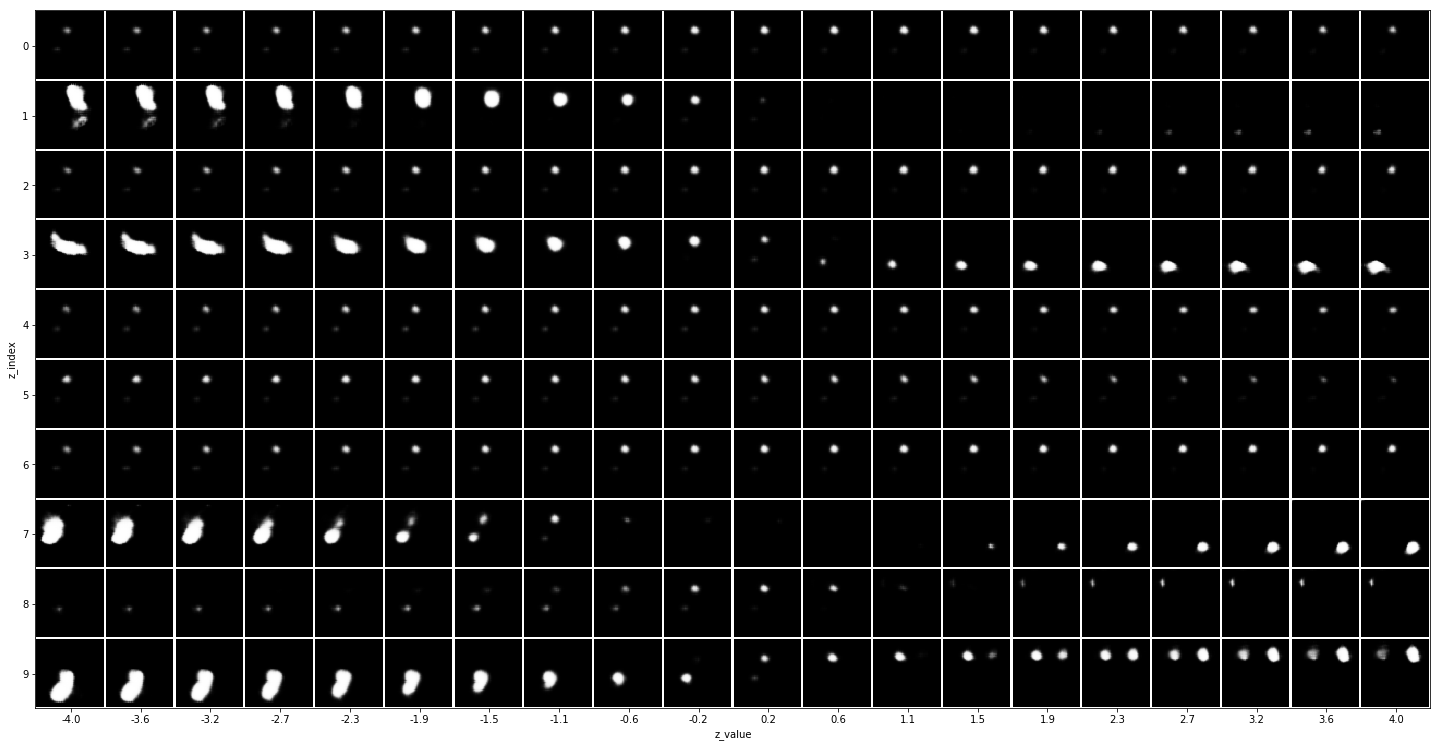

In [248]:
z_visual((encoder, decoder))

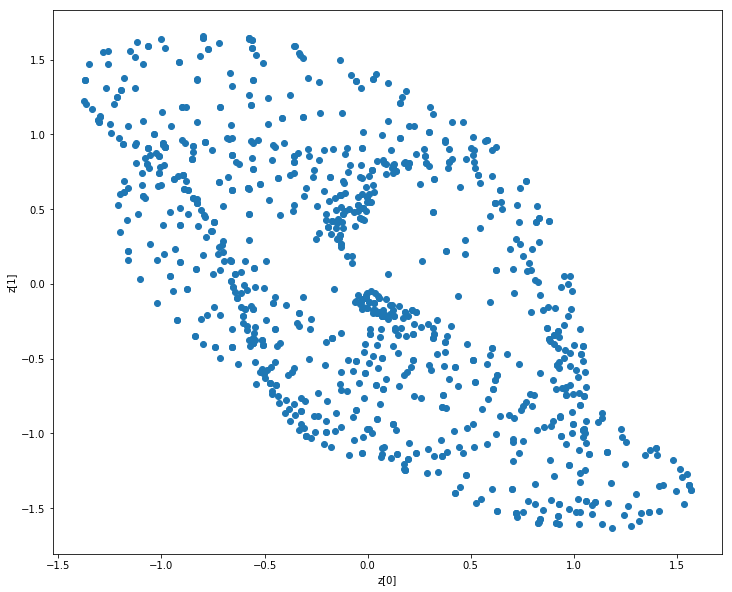

ValueError: Error when checking : expected z_sampling to have shape (6,) but got array with shape (2,)

In [190]:
plot_blob_results((encoder, decoder), x_test, batch_size=batch_size, model_name="vae_cnn")